## Capstone 3: Store Item Demand Forecasting 

**1. Data Loading and Wrangling**

In [216]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller


In [2]:
#load the original downloaded excel file from Kaggle

df_train = pd.read_csv('train.csv')
print("First 5 samples of training data \n\n", df_train.head())


First 5 samples of training data 

          date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10


First 5 samples of test data 

    id        date  store  item
0   0  2018-01-01      1     1
1   1  2018-01-02      1     1
2   2  2018-01-03      1     1
3   3  2018-01-04      1     1
4   4  2018-01-05      1     1


The raw data is loaded. Input data has four columns: date, store, item, sales. The data will be split based on time and the last 3 months of the data will be used as test and rest for training. The sales value from test data has to be forecasted and will be compared with the true sales data. 

Next we will analyze the data which include:
- Check shape of the file
- Check datatype
- Generate desciptive statistics for each column
- Check for null values


In [3]:
print("The shape of the input data is: \n", df_train.shape,"\n")

print("\nThe datatypes for the columns in the input data are:")
print(df_train.info())

The shape of the training data is: 
 (913000, 4) 

The shape of the test data is: 
 (45000, 4)

The datatypes for the columns in the training data are:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None

The datatypes for the columns in the test data are:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   date    45000 non-null  object
 2   store   45000 non-null  int64 
 3   item    45000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB
None


Out of the four columns 'store', 'item' and 'sales' have integer values and 'date' seems to be an object. For time series analysis this column will be converted to a pandas date-time object. 

For the test data, there is no sales as it is meant to be forecasted. The data follows the same format as the trainig data. 

In [4]:
print("Basic statistics for the columns from the input data: \n")
print(df_train.describe().round(2))


Basic statistics for the columns from the training data: 

           store       item      sales
count  913000.00  913000.00  913000.00
mean        5.50      25.50      52.25
std         2.87      14.43      28.80
min         1.00       1.00       0.00
25%         3.00      13.00      30.00
50%         5.50      25.50      47.00
75%         8.00      38.00      70.00
max        10.00      50.00     231.00

Basic statistics for the columns from the test data: 

             id     store      item
count  45000.00  45000.00  45000.00
mean   22499.50      5.50     25.50
std    12990.53      2.87     14.43
min        0.00      1.00      1.00
25%    11249.75      3.00     13.00
50%    22499.50      5.50     25.50
75%    33749.25      8.00     38.00
max    44999.00     10.00     50.00


Let us explore more for the training data to find out what are the unique store_id values and unique item_id values. 

In [5]:
print("Below is a list of unique store ids in the input data and their representation: \n") 
print(df_train['store'].value_counts())

Below is a list of unique store ids in the training data and their representation: 

1     91300
2     91300
3     91300
4     91300
5     91300
6     91300
7     91300
8     91300
9     91300
10    91300
Name: store, dtype: int64


In [6]:
print("Below is a list of unique items in the input data and their representation: \n") 
print(df_train['item'].value_counts().sort_index())

Below is a list of unique items in the training data and their representation: 

1     18260
2     18260
3     18260
4     18260
5     18260
6     18260
7     18260
8     18260
9     18260
10    18260
11    18260
12    18260
13    18260
14    18260
15    18260
16    18260
17    18260
18    18260
19    18260
20    18260
21    18260
22    18260
23    18260
24    18260
25    18260
26    18260
27    18260
28    18260
29    18260
30    18260
31    18260
32    18260
33    18260
34    18260
35    18260
36    18260
37    18260
38    18260
39    18260
40    18260
41    18260
42    18260
43    18260
44    18260
45    18260
46    18260
47    18260
48    18260
49    18260
50    18260
Name: item, dtype: int64


There are a total of 10 stores and each store sells 50 items. The data is very uniform in representation i.e. the number of datapoints for each subset of store-item combination is exactly the same. Very likely this is a synthetic dataset. 

In [7]:
print("Below is a list of null values in the input dataset:")
print(df_train.isnull().sum())


Below is a list of null values in the trianing dataset:
date     0
store    0
item     0
sales    0
dtype: int64

Below is a list of null values in the test dataset:
id       0
date     0
store    0
item     0
dtype: int64


There are no null values in the training and the test data. The data is clean and ready for analysis. 

**2) EDA**

- Convert time variable to pandas datetime object
- Generate other columns for date such as day of the week, month, year etc. 
- Check total time range: start date, end date, total number of days
- Check for missing days 
- Generate summary stats for each store
- Generate summary stats for each item
- Plot histogram of daily sales for each store and all stores combined
- Plot box plots for each day of the week for each store and all stores combined
- Time plot of daily sales for each store
- Time plot of daily sales for each store with a moving average window
- Time plot of weekly sales for each store
- Time plot of monthly sales for each store
- Correlation plot for daily sales from different stores
- Check for any degenracies in the data

In [8]:
# Convert time variable to pandas datetime object
# Generate other columns for date such as day of the week, month, year etc.

df_train['date'] = pd.to_datetime(df_train['date'], format="%Y-%m-%d")

df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day_of_year'] = df_train['date'].dt.dayofyear
df_train['week'] = df_train['date'].dt.weekofyear
df_train['day_of_week'] = df_train['date'].dt.dayofweek + 1

df_train.head(40)

date  store  item  sales  year  month  day_of_year  week  day_of_week
0  2013-01-01      1     1     13  2013      1            1     1            2
1  2013-01-02      1     1     11  2013      1            2     1            3
2  2013-01-03      1     1     14  2013      1            3     1            4
3  2013-01-04      1     1     13  2013      1            4     1            5
4  2013-01-05      1     1     10  2013      1            5     1            6
5  2013-01-06      1     1     12  2013      1            6     1            7
6  2013-01-07      1     1     10  2013      1            7     2            1
7  2013-01-08      1     1      9  2013      1            8     2            2
8  2013-01-09      1     1     12  2013      1            9     2            3
9  2013-01-10      1     1      9  2013      1           10     2            4
10 2013-01-11      1     1      9  2013      1           11     2            5
11 2013-01-12      1     1      7  2013      1           12     2            6
12 2013-01-13      1     1     10  2013      1           13     2            7
13 2013-01-14      1     1     12  2013      1           14     3            1
14 2013-01-15      1     1      5  2013      1           15     3            2
15 2013-01-16      1     1      7  2013      1           16     3            3
16 2013-01-17      1     1     16  2013      1           17     3            4
17 2013-01-18      1     1      7  2013      1           18     3            5
18 2013-01-19      1     1     18  2013      1           19     3            6
19 2013-01-20      1     1     15  2013      1           20     3            7
20 2013-01-21      1     1      8  2013      1           21     4            1
21 2013-01-22      1     1      7  2013      1           22     4            2
22 2013-01-23      1     1      9  2013      1           23     4            3
23 2013-01-24      1     1      8  2013      1           24     4            4
24 2013-01-25      1     1     14  2013      1           25     4            5
25 2013-01-26      1     1     12  2013      1           26     4            6
26 2013-01-27      1     1     12  2013      1           27     4            7
27 2013-01-28      1     1     11  2013      1           28     5            1
28 2013-01-29      1     1      6  2013      1           29     5            2
29 2013-01-30      1     1      9  2013      1           30     5            3
30 2013-01-31      1     1     13  2013      1           31     5            4
31 2013-02-01      1     1     11  2013      2           32     5            5
32 2013-02-02      1     1     21  2013      2           33     5            6
33 2013-02-03      1     1     15  2013      2           34     5            7
34 2013-02-04      1     1     14  2013      2           35     6            1
35 2013-02-05      1     1      9  2013      2           36     6            2
36 2013-02-06      1     1     10  2013      2           37     6            3
37 2013-02-07      1     1     13  2013      2           38     6            4
38 2013-02-08      1     1     11  2013      2           39     6            5
39 2013-02-09      1     1     14  2013      2           40     6            6

In [9]:
# Check total time range: start date, end date, total number of days
# Check for missing days

print('The start date for the dataset is:\n', df_train['date'].min().date())
print('The end date for the dataset is:\n', df_train['date'].max().date())

tot_days = (df_train['date'].max().date() - df_train['date'].min().date()).days + 1
print('The total number of days for the dataset is:\n', tot_days)

print('The total number of entries for the dataset is:\n', tot_days*10*50)

The start date for the dataset is:
 2013-01-01
The end date for the dataset is:
 2017-12-31
The total number of days for the dataset is:
 1826
The total number of entries for the dataset is:
 913000


There are no missing days in the dataset. There is an entry for each store, item and day in this dataset. 

In [10]:
# Generate summary stats for each store
# Generate summary stats for each item

store_sales = df_train.groupby('store', as_index=True)['sales'].agg(['count', 'sum', 'mean', 'median', 'std', 'min', 'max']).reset_index()
item_sales = df_train.groupby('item', as_index=True)['sales'].agg(['count', 'sum', 'mean', 'median', 'std', 'min', 'max']).reset_index()

print("Summary statistics for sales at each store")
print(store_sales)
print("\nSummary statistics for sales for each item")
print(item_sales)

Summary statistics for sales at each store
   store  count      sum       mean  median        std  min  max
0      1  91300  4315603  47.268379    44.0  24.006252    1  155
1      2  91300  6120128  67.033165    62.0  33.595810    3  231
2      3  91300  5435144  59.530602    55.0  29.974102    3  196
3      4  91300  5012639  54.902946    51.0  27.733097    4  186
4      5  91300  3631016  39.770164    37.0  20.365757    2  130
5      6  91300  3627670  39.733516    37.0  20.310451    0  134
6      7  91300  3320009  36.363735    34.0  18.684825    1  122
7      8  91300  5856169  64.142048    60.0  32.231751    4  204
8      9  91300  5025976  55.049025    51.0  27.832186    4  195
9     10  91300  5360158  58.709288    54.0  29.554994    3  187

Summary statistics for sales for each item
    item  count      sum       mean  median        std  min  max
0      1  18260   401384  21.981599    21.0   8.468922    1   59
1      2  18260  1069564  58.574151    56.0  20.093015    9  150
2  

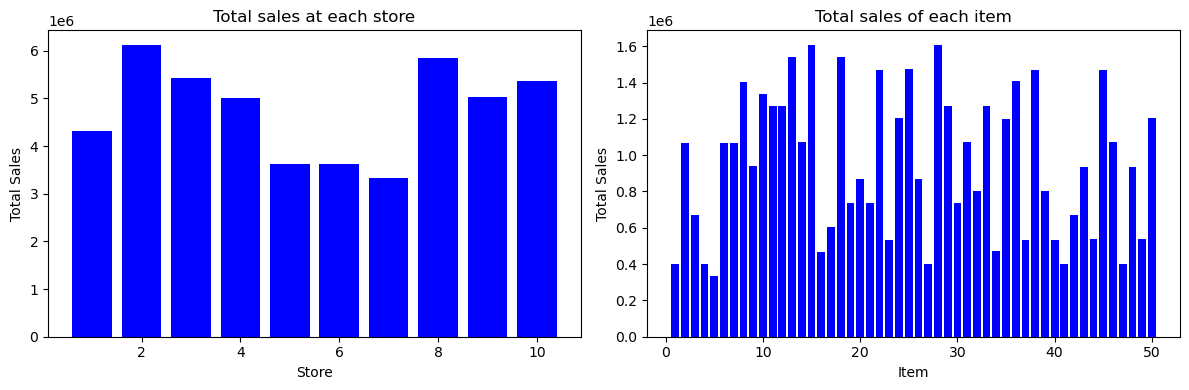

In [11]:
# Plot the total sales for each store and item 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot in the first subplot (index 0)
ax[0].bar(store_sales['store'], store_sales['sum'], color='b')
ax[0].set_title("Total sales at each store")
ax[0].set_xlabel('Store')
ax[0].set_ylabel('Total Sales')

# Plot in the second subplot (index 1)
ax[1].bar(item_sales['item'], item_sales['sum'], color='b')
ax[1].set_title("Total sales of each item")
ax[1].set_xlabel('Item')
ax[1].set_ylabel('Total Sales')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [12]:
# Calculate daily sales for each store and for all stores combined

daily_sales = df_train.groupby('date')['sales'].sum().reset_index()
daily_store_sales = df_train.groupby(['date', 'store'])['sales'].sum().reset_index()

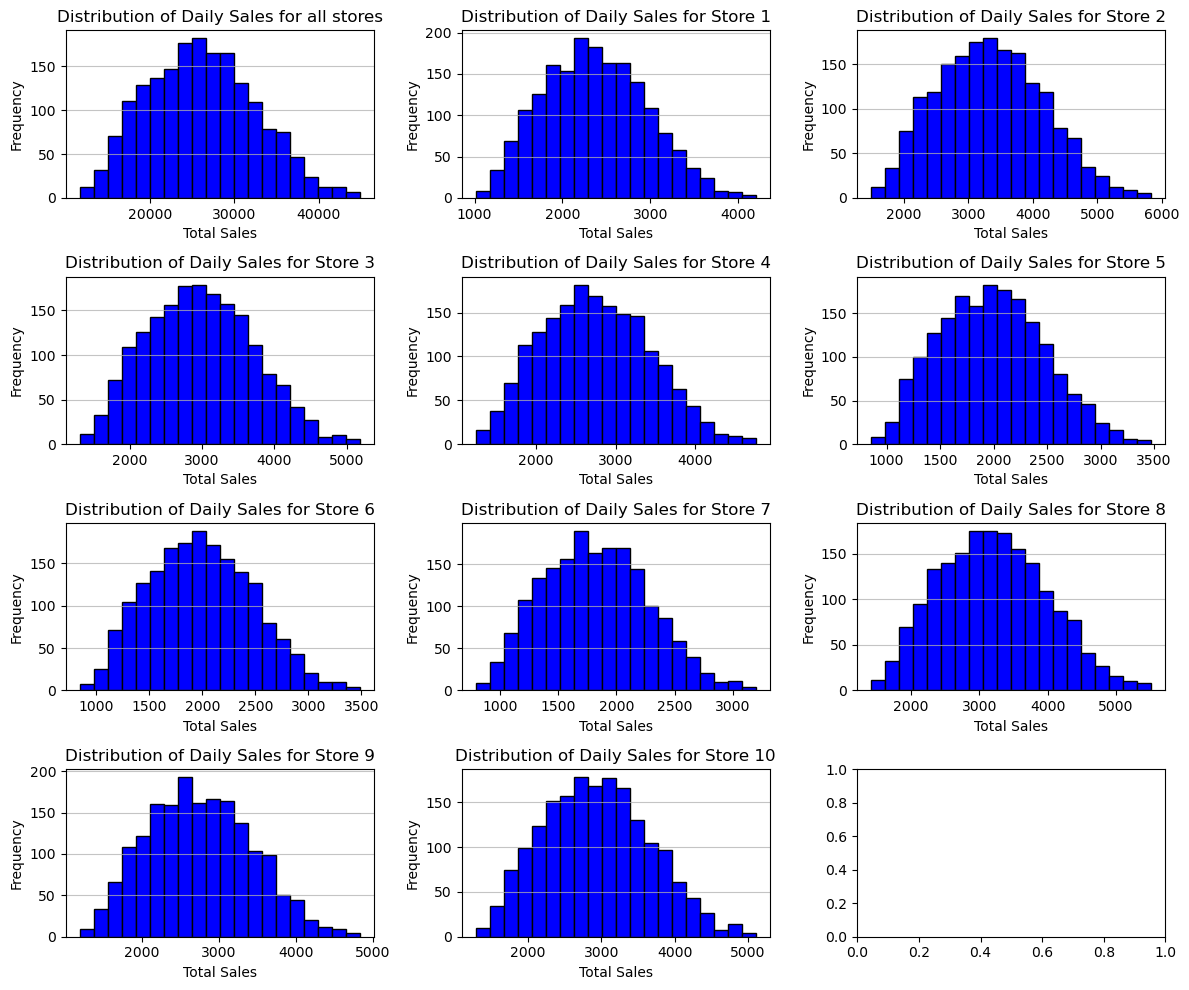

In [13]:
# Plot histograms of daily sales all for each store and all stores combined 

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
custom_bins = 20

ax[0, 0].hist(daily_sales['sales'], bins=custom_bins, color='b', edgecolor='black')
ax[0, 0].set_title(f'Distribution of Daily Sales for all stores')
ax[0, 0].set_xlabel('Total Sales')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].grid(axis='y', alpha=0.75)

for store_number in range(1, 11):  # Range from 1 to 10 (inclusive)
    i, j = divmod(store_number, 3)  # Calculate the row and column indices based on store_number
    
    # Plot starting from the first row and second column
    store_data = daily_store_sales[daily_store_sales['store'] == store_number]['sales']

    ax[i, j].hist(store_data, bins=custom_bins, color='b', edgecolor='black')
    ax[i, j].set_title(f'Distribution of Daily Sales for Store {store_number}')
    ax[i, j].set_xlabel('Total Sales')
    ax[i, j].set_ylabel('Frequency')
    ax[i, j].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

The distribution of the sales for each store are very similar. 

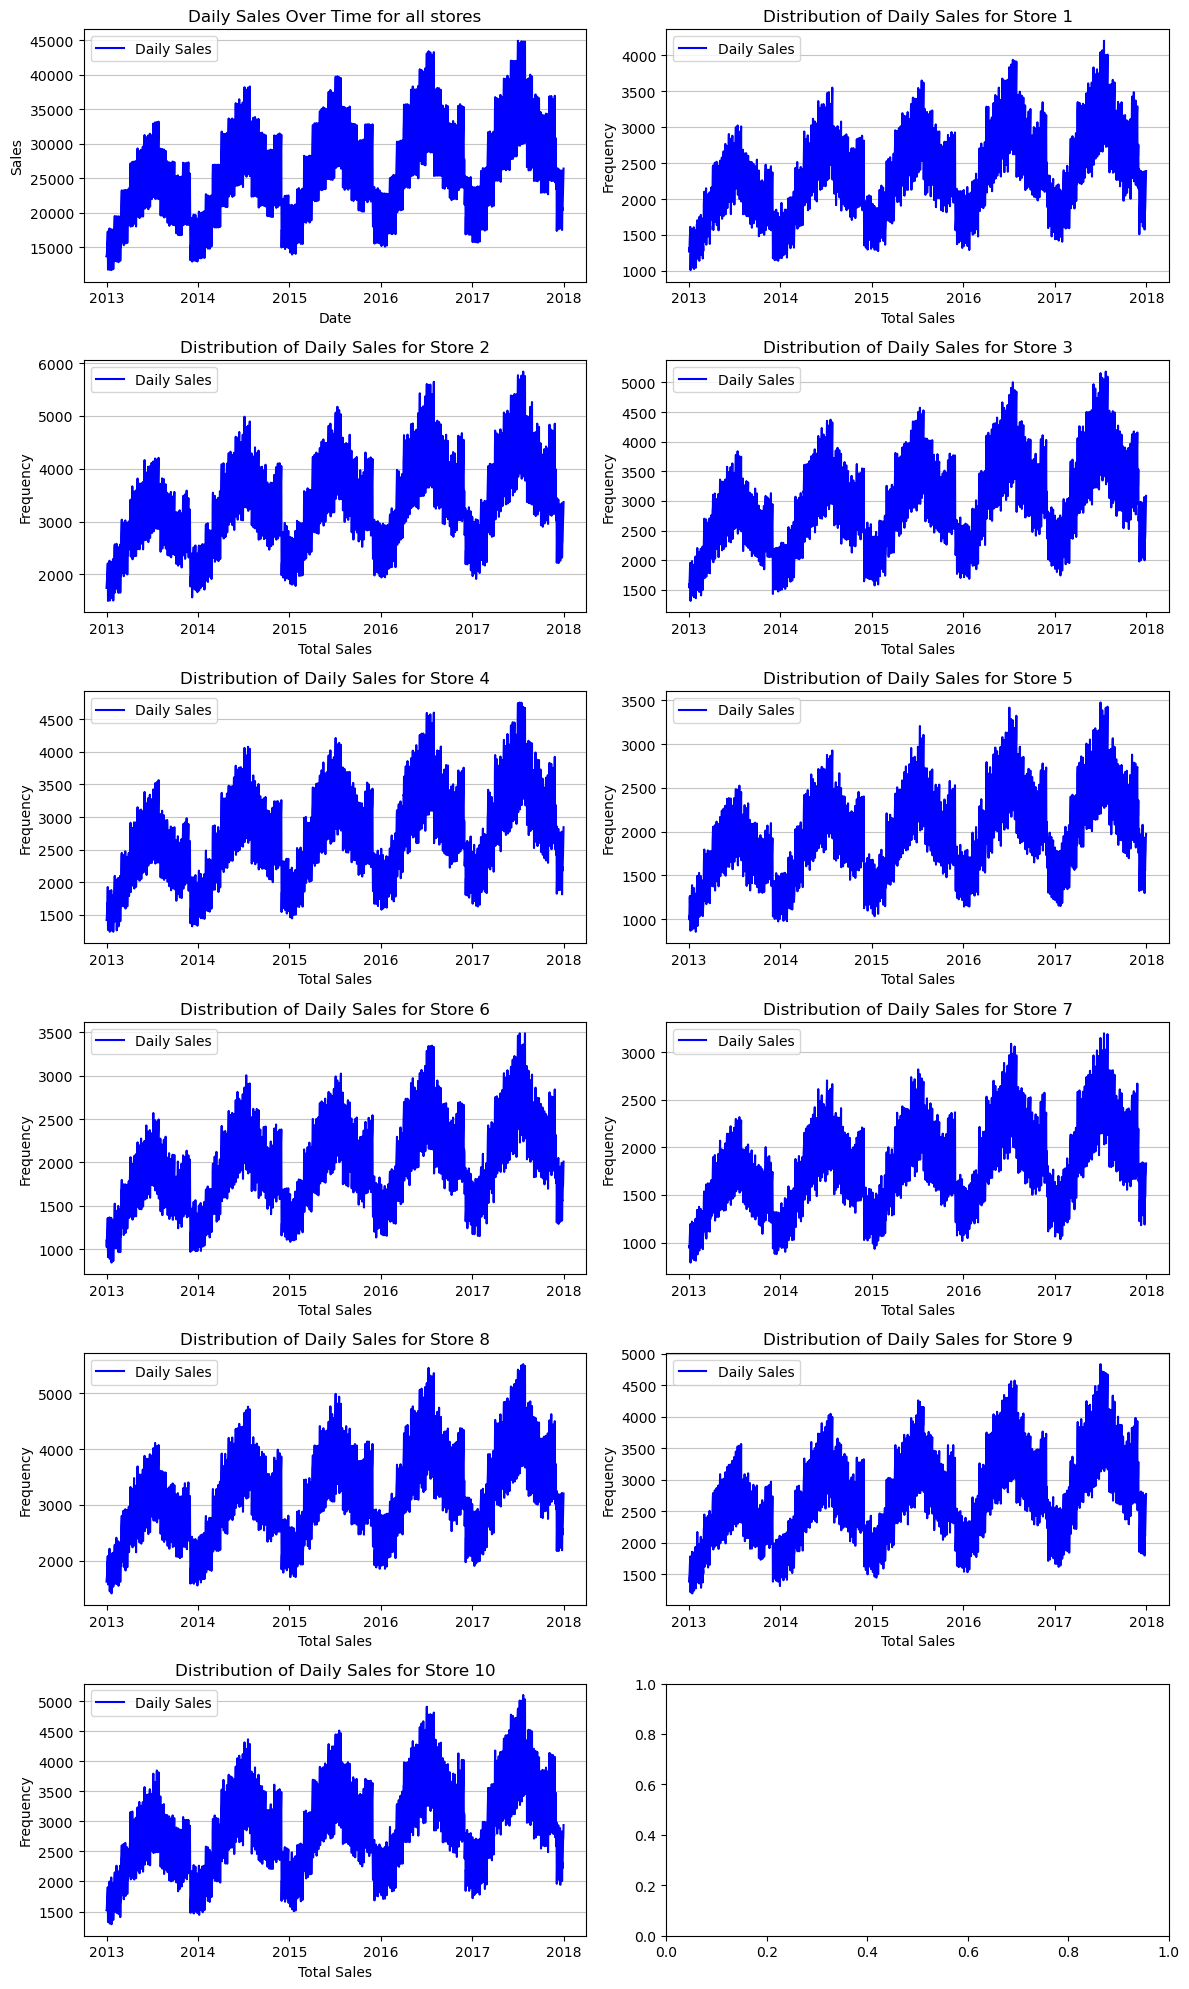

In [14]:
# Time plots of daily sales for each store and all stores combined

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(12, 20))

ax[0,0].plot(daily_sales['date'], daily_sales['sales'], label='Daily Sales', color='b', linestyle='-')
ax[0,0].set_title('Daily Sales Over Time for all stores')
ax[0,0].set_xlabel('Date')
ax[0,0].set_ylabel('Sales')
ax[0,0].legend(loc='upper left')
ax[0,0].grid(axis='y', alpha=0.75)

for store_number in range(1, 11):  # Range from 1 to 10 (inclusive)
    i, j = divmod(store_number, 2)  # Calculate the row and column indices based on store_number
    
    # Plot starting from the second row and first column
    store_data = daily_store_sales[daily_store_sales['store'] == store_number]['sales']
    store_date = daily_store_sales[daily_store_sales['store'] == store_number]['date']

    ax[i, j].plot(store_date, store_data, label='Daily Sales', color='b', linestyle='-')
    ax[i, j].set_title(f'Distribution of Daily Sales for Store {store_number}')
    ax[i, j].set_xlabel('Total Sales')
    ax[i, j].set_ylabel('Frequency')
    ax[i, j].legend(loc='upper left')
    ax[i, j].grid(axis='y', alpha=0.75)
    
plt.tight_layout()
plt.show()

The time series plots ofr each store are very alike with obvious trend and seasonality patterns which will be explored later. 

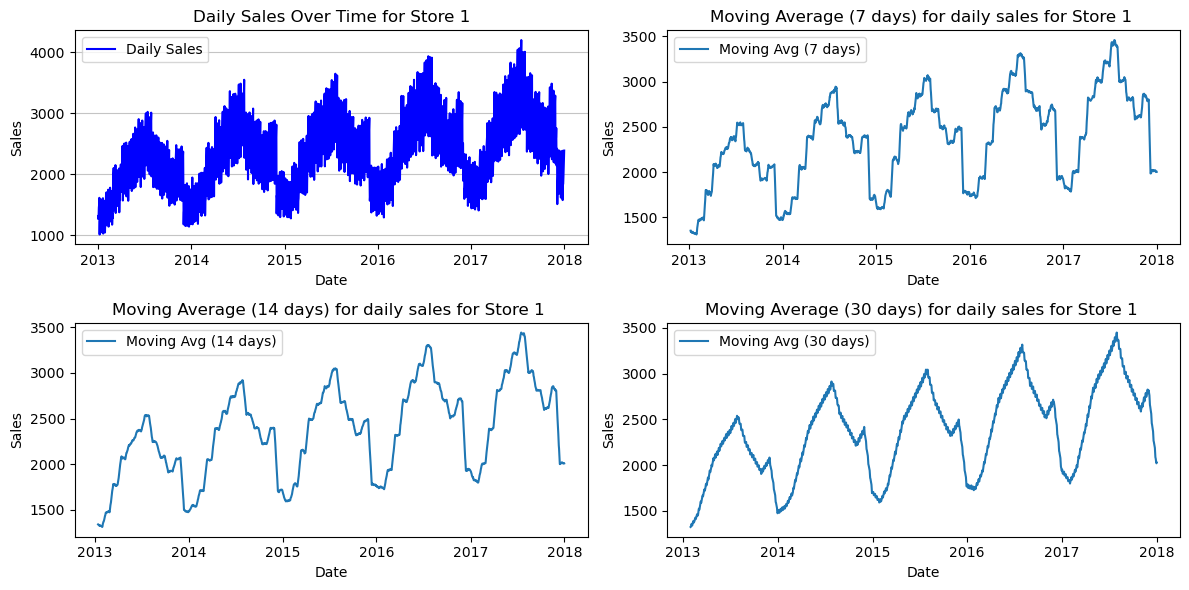

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

daily_store1_sales = daily_store_sales[daily_store_sales['store'] == 1]
ax[0,0].plot(daily_store1_sales['date'], daily_store1_sales['sales'], label='Daily Sales', color='b', linestyle='-')
ax[0,0].set_title('Daily Sales Over Time for Store 1')
ax[0,0].set_xlabel('Date')
ax[0,0].set_ylabel('Sales')
ax[0,0].legend(loc='upper left')
ax[0,0].grid(axis='y', alpha=0.75)

# Generate moving average plots for different window sizes
window_sizes = [7, 14, 30]  # Define the window sizes for moving averages
iii = 1

for window_size in window_sizes:
    # Calculate the moving average using the specified window size
    moving_avg = daily_store1_sales['sales'].rolling(window=window_size).mean()
    
    i, j = divmod(iii, 2)
    iii = iii + 1

    # Plot the moving average on separate subplots
    ax[i,j].plot(daily_store1_sales['date'], moving_avg, label=f'Moving Avg ({window_size} days)')  
    ax[i,j].set_xlabel('Date')
    ax[i,j].set_ylabel('Sales')
    ax[i,j].set_title(f'Moving Average ({window_size} days) for daily sales for Store 1 ')
    ax[i,j].legend(loc='upper left')

plt.tight_layout()
plt.show()   

The moving verage plots show very strong yearly seasonal effects. There could be some monthly seasonality as well. 

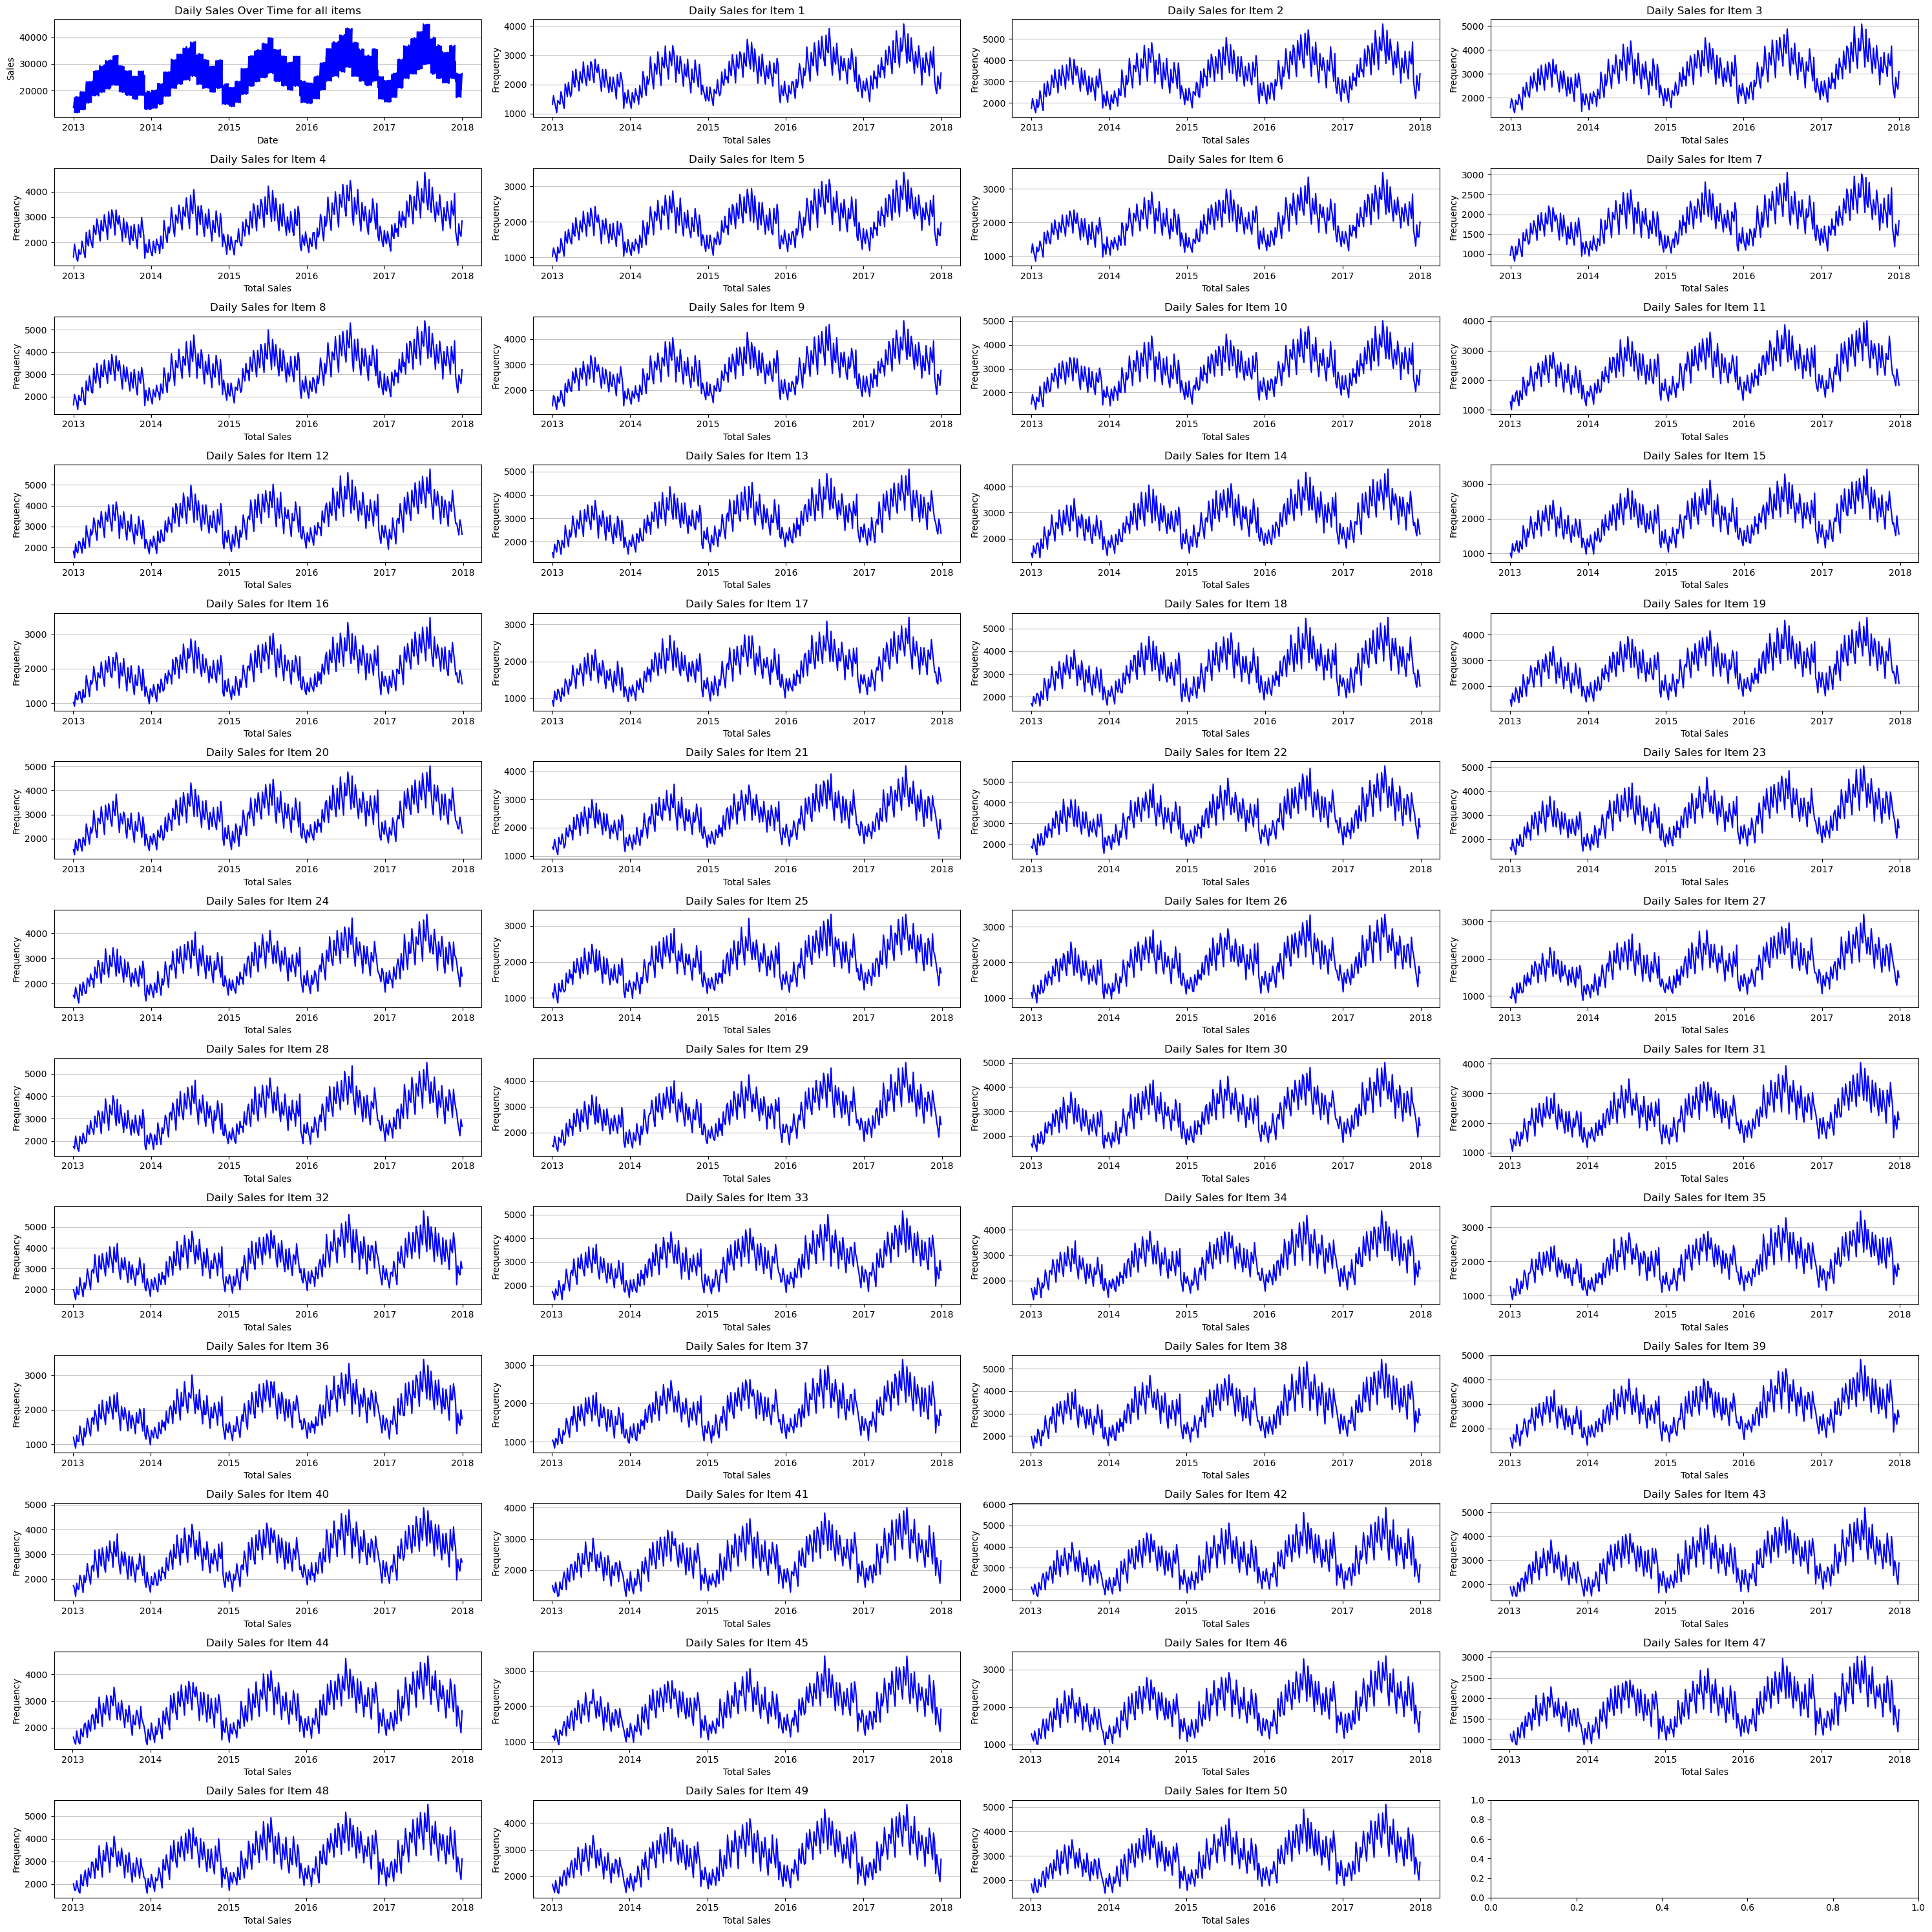

In [16]:
# Calculate daily sales for each item and plot the time series plots

daily_item_sales = df_train.groupby(['date', 'item'])['sales'].sum().reset_index()

fig, ax = plt.subplots(nrows=13, ncols=4, figsize=(30, 30))

ax[0,0].plot(daily_sales['date'], daily_sales['sales'], label='Daily Sales', color='b', linestyle='-')
ax[0,0].set_title('Daily Sales Over Time for all items')
ax[0,0].set_xlabel('Date')
ax[0,0].set_ylabel('Sales')
ax[0,0].grid(axis='y', alpha=0.75)

for item_number in range(1, 51):  # Range from 1 to 50 (inclusive)
    i, j = divmod(item_number, 4)  # Calculate the row and column indices based on item_number
    
    # Plot starting from the second row and first column
    item_data = daily_store_sales[daily_item_sales['item'] == item_number]['sales']
    item_date = daily_store_sales[daily_item_sales['item'] == item_number]['date']

    ax[i, j].plot(item_date, item_data, label='Daily Sales', color='b', linestyle='-')
    ax[i, j].set_title(f'Daily Sales for Item {item_number}')
    ax[i, j].set_xlabel('Total Sales')
    ax[i, j].set_ylabel('Frequency')
    ax[i, j].grid(axis='y', alpha=0.75)
    
plt.tight_layout()
plt.show()


Again, the plots of each item is very similar. Seems like a synthetic dataset generated with the same parameters for each store and each item plus some noise. Next we will check for any degeneracies in the data. 


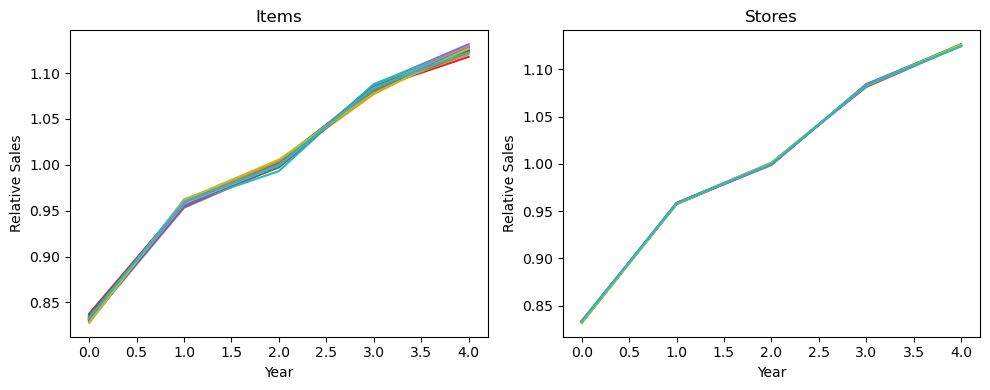

In [17]:
# Calculate mean sales for each combination of 'year' and 'item'
agg_year_item = df_train.groupby(['year', 'item'])['sales'].mean().unstack().values

# Calculate mean sales for each combination of 'year' and 'store'
agg_year_store = df_train.groupby(['year', 'store'])['sales'].mean().unstack().values

# Normalize by the mean sales for each item or store across all years
agg_year_item_relative = agg_year_item / agg_year_item.mean(axis=0)
agg_year_store_relative = agg_year_store / agg_year_store.mean(axis=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(agg_year_item_relative)
ax[0].set_title("Items")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Relative Sales")

plt.subplot(122)
ax[1].plot(agg_year_store_relative)
ax[1].set_title("Stores")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Relative Sales")

plt.tight_layout()
plt.show()
#print("All items and stores seem to enjoy a similar growth in sales over the years.")

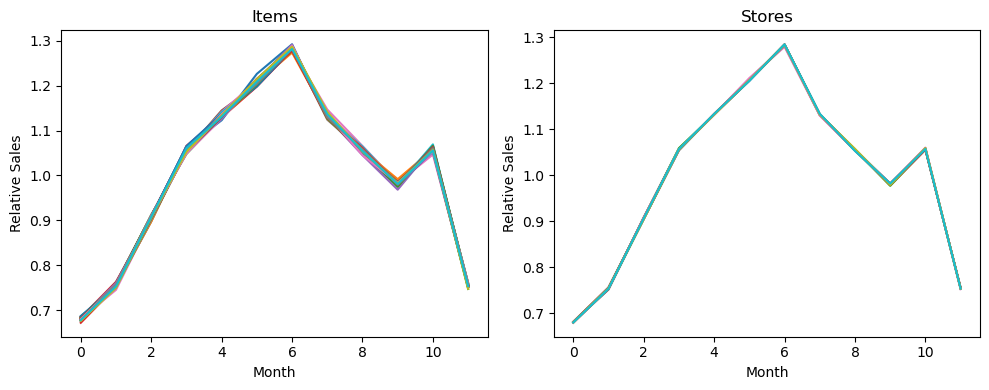

In [18]:
# Calculate mean sales for each combination of 'year' and 'item'
agg_month_item = df_train.groupby(['month', 'item'])['sales'].mean().unstack().values

# Calculate mean sales for each combination of 'year' and 'store'
agg_month_store = df_train.groupby(['month', 'store'])['sales'].mean().unstack().values

# Normalize by the mean sales for each item or store across all years
agg_month_item_relative = agg_month_item / agg_month_item.mean(axis=0)
agg_month_store_relative = agg_month_store / agg_month_store.mean(axis=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(agg_month_item_relative)
ax[0].set_title("Items")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Relative Sales")

plt.subplot(122)
ax[1].plot(agg_month_store_relative)
ax[1].set_title("Stores")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Relative Sales")

plt.tight_layout()
plt.show()
#print("All items and stores seem to enjoy a similar growth in sales over the years.")

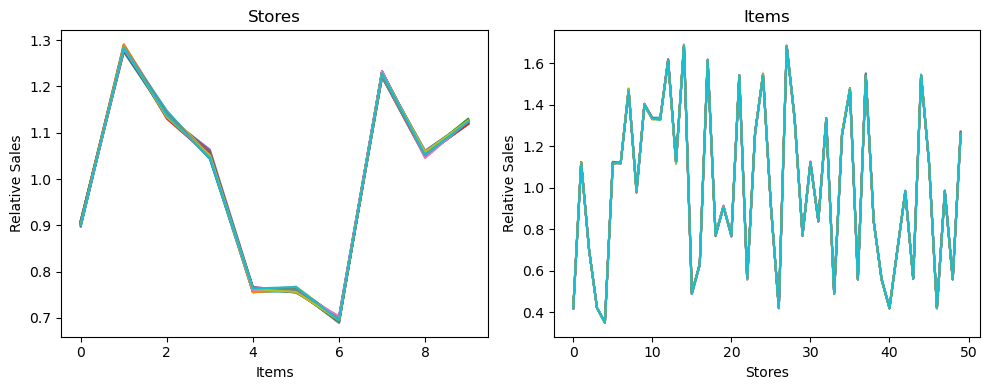

In [19]:
# Calculate mean sales for each combination of 'store' and 'item'
agg_store_item = df_train.groupby(['store', 'item'])['sales'].mean().unstack().values

# Calculate mean sales for each combination of 'year' and 'store'
agg_month_store = df_train.groupby(['month', 'store'])['sales'].mean().unstack().values

# Normalize by the mean sales for each item or store across all years
agg_store_item_relative = agg_store_item / agg_store_item.mean(axis=0)
agg_item_store_relative = agg_store_item.T / agg_store_item.T.mean(axis=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(agg_store_item_relative)
ax[0].set_title("Stores")
ax[0].set_xlabel("Items")
ax[0].set_ylabel("Relative Sales")

plt.subplot(122)
ax[1].plot(agg_item_store_relative)
ax[1].set_title("Items")
ax[1].set_xlabel("Stores")
ax[1].set_ylabel("Relative Sales")

plt.tight_layout()
plt.show()
#print("All items and stores seem to enjoy a similar growth in sales over the years.")

From the plots above we can see that there are no apparant degeneracies in the data and that no relationship exists between store and item over month/year. 

<Figure size 640x480 with 0 Axes>

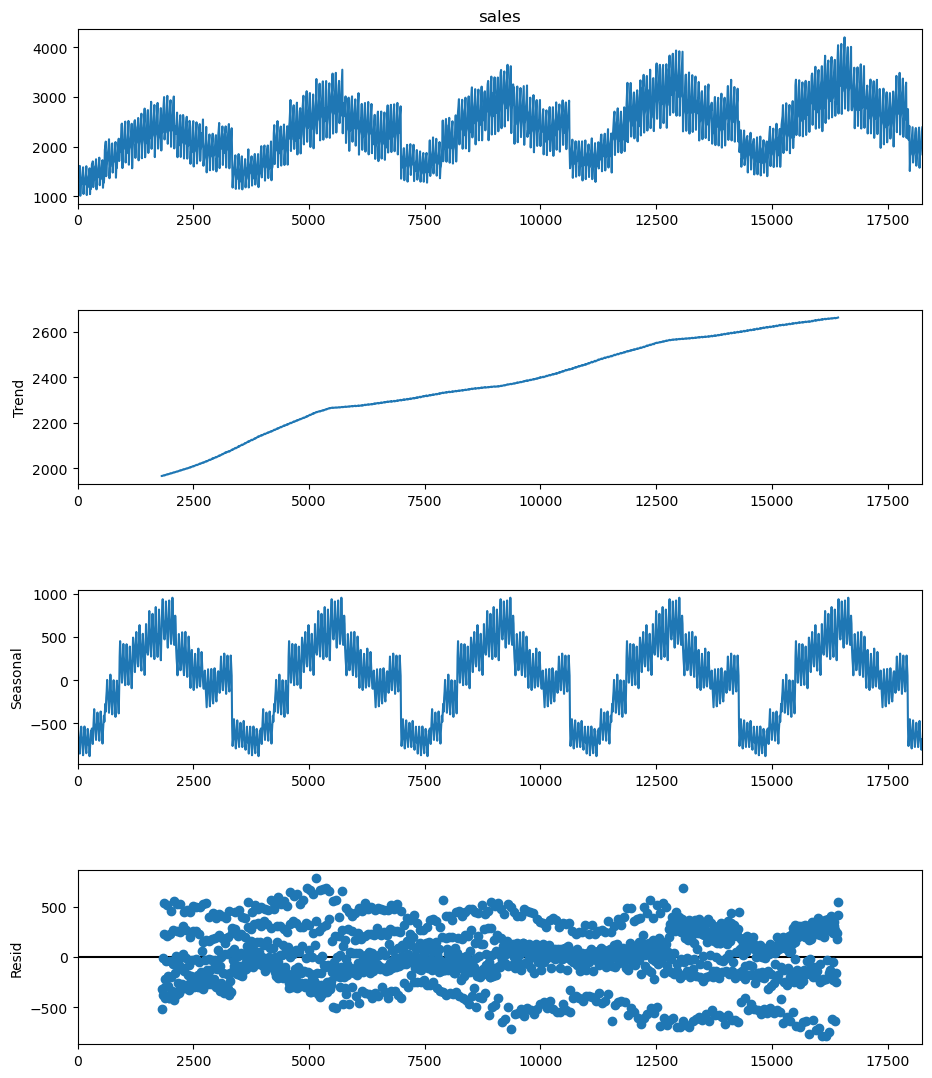

In [20]:
# Decompsing the store 1 daily sales plot into trend, seasonality and resildual assuming an additive model

result = seasonal_decompose(daily_store1_sales['sales'], model='additive', period=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 12)

<Figure size 640x480 with 0 Axes>

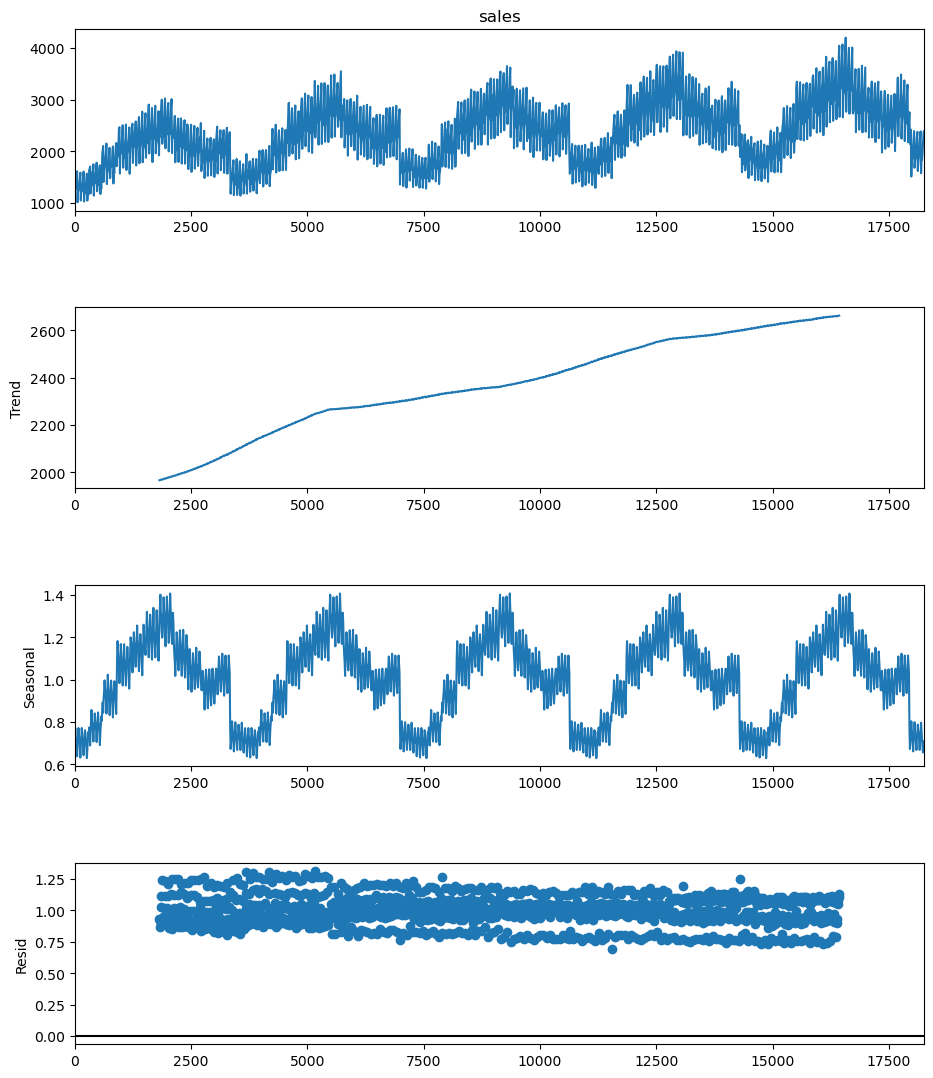

In [21]:
# Decompsing the store 1 daily sales plot into trend, seasonality and resildual assuming an additive model

result = seasonal_decompose(daily_store1_sales['sales'], model='multiplicative', period=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 12)

From the decomposition plots we can see that the additive model gives a better estimate of trend and seasonlity because the residuals are more normally distributed and random. 

**3) Data Preprocessing and ARIMA modeling**

- Generate two datasets for time series prediction
    - Timeseries1 = Store 1 item 1
- Divide the data into training data and test data based on date 
- For ARIMA model, estimate parameters p,d,q
    - p is the order of the autoregressive component (AR)
    - q is the order of the moving average component (MA)
    - d is the order of the differencing required to make the time-series stationary
- Estimate p and q from the ACF and PACF plots
- Test for stationarity using Dickey-Fuller test
    - If the data is not stationary then test again for first difference
    - Continue taking nth difference until the data is stationary 

In [22]:
#ts_s1_i1 = df_train[df_train['store'] == 1 && df_train['item'] == 1 ] ['date','sales']

ts_s1_i1 = df_train[(df_train['store'] == 1) & (df_train['item'] == 1)][['date', 'sales']]

In [23]:
print("The shape of the store1 item1 sales data is: \n", ts_s1_i1.shape,"\n")

print("First five rows of the store1 item1 sales data\n", ts_s1_i1.head(),"\n")

The shape of the store1 item1 sales data is: 
 (1826, 2) 

The shape of the store1 all items sales data is: 
 (1826, 2) 

First five rows of the store1 item1 sales data
         date  sales
0 2013-01-01     13
1 2013-01-02     11
2 2013-01-03     14
3 2013-01-04     13
4 2013-01-05     10 

First five rows of the store1 all items sales data
         date  sales
0 2013-01-01   1316
1 2013-01-02   1264
2 2013-01-03   1305
3 2013-01-04   1452
4 2013-01-05   1499


In [25]:
print('The start date for the store1 item1 sales dataset is:\n', ts_s1_i1['date'].min().date())
print('The end date for the store1 item1 sales dataset is:\n', ts_s1_i1['date'].max().date())

The start date for the store1 item1 sales dataset is:
 2013-01-01
The end date for the store1 item1 sales dataset is:
 2017-12-31


In [42]:
#Split the data for forecasting 3 months fo sales data. Test data will be from 2017-10-01 and rest will be for trianing. 

ts_s1_i1_train = ts_s1_i1[ts_s1_i1['date'] < '2017-10-01']
ts_s1_i1_test = ts_s1_i1[ts_s1_i1['date'] >= '2017-10-01']

In [27]:
# Verify whether the start dates and end dates of the training and test data are as expected

print('The start date for the training dataset is:\n', ts_s1_i1_train['date'].min().date())
print('The end date for the training dataset is:\n', ts_s1_i1_train['date'].max().date())

print('\nThe start date for the test dataset is:\n', ts_s1_i1_test['date'].min().date())
print('The end date for the test dataset is:\n', ts_s1_i1_test['date'].max().date())

The start date for the training dataset is:
 2013-01-01
The end date for the training dataset is:
 2017-09-30

The start date for the test dataset is:
 2013-01-01
The end date for the test dataset is:
 2017-09-30


In [28]:
# Define a function that tests stationarity of a time series using the Dickey-Fuller test and prints out test statistics
# Additionaly the time series and its rolling mean and rolling standard deviations are also plotted

def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(8, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 25 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

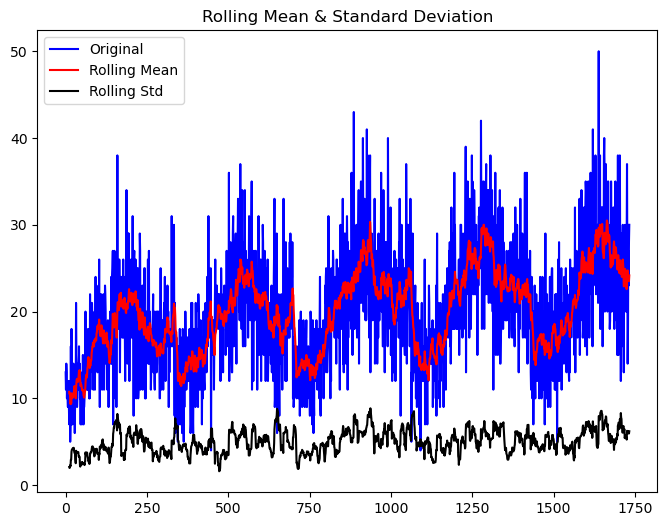

Results of Dickey-Fuller Test:
p-value = 0.0413. The series is likely non-stationary.
Test Statistic                   -2.936551
p-value                           0.041260
#Lags Used                       23.000000
Number of Observations Used    1710.000000
Critical Value (1%)              -3.434180
Critical Value (5%)              -2.863232
Critical Value (10%)             -2.567671
dtype: float64


In [29]:
# Test stationarity for the store1 item1 sales data

test_stationarity(ts_s1_i1_train['sales'])

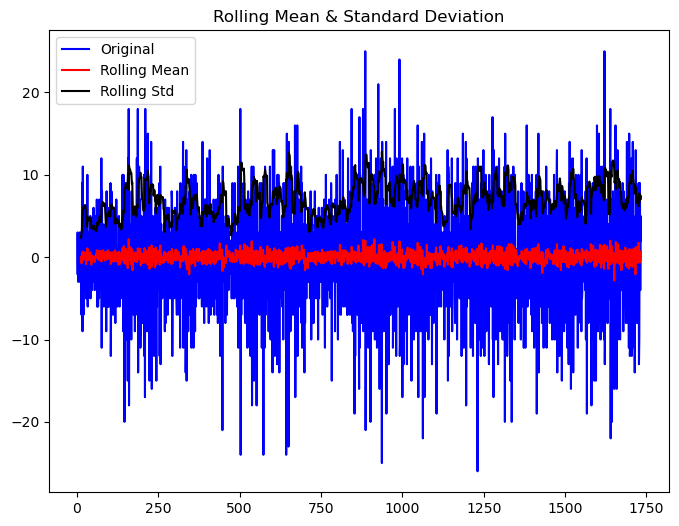

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.232606e+01
p-value                        6.585276e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.710000e+03
Critical Value (1%)           -3.434180e+00
Critical Value (5%)           -2.863232e+00
Critical Value (10%)          -2.567671e+00
dtype: float64


In [30]:
# Generate first difference for the store1 item1 dataset and test for stationarity

ts_s1_i1_train_d1 = ts_s1_i1_train['sales'] - ts_s1_i1_train['sales'].shift(1)
ts_s1_i1_train_d1.dropna(inplace=True)
test_stationarity(ts_s1_i1_train_d1)

Both the time series become stationary after taking first difference. Hence, we can use order 1 for d parameter in ARIMA modeling for both the datasets. Next we will generate ACF and PACF of the datasets. 

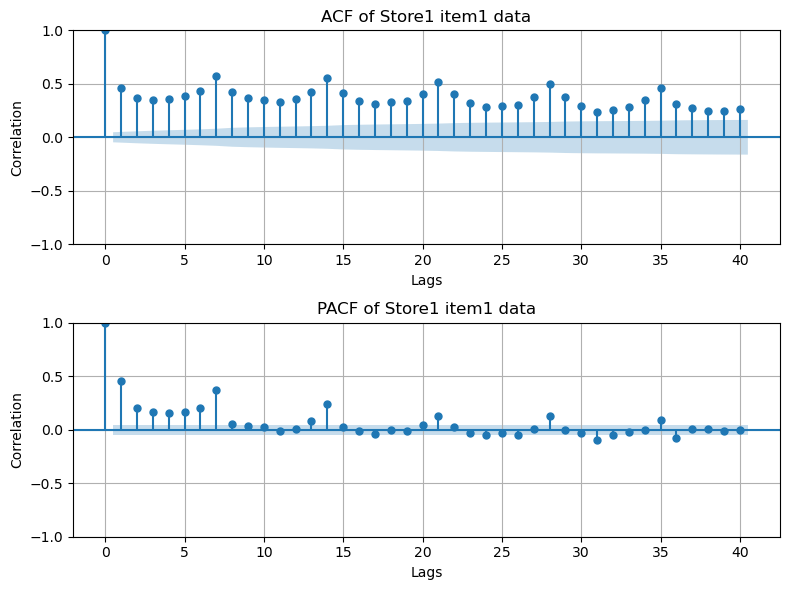

In [33]:
# Plot the ACF and PACF of the store1 item1 data

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

sm.graphics.tsa.plot_acf(ts_s1_i1_train.sales, lags=40, ax=ax[0])
ax[0].set_title("ACF of Store1 item1 data")
ax[0].set_xlabel("Lags")
ax[0].set_ylabel("Correlation")
ax[0].grid(True)

sm.graphics.tsa.plot_pacf(ts_s1_i1_train.sales, lags=40, ax=ax[1])
ax[1].set_title("PACF of Store1 item1 data")
ax[1].set_xlabel("Lags")
ax[1].set_ylabel("Correlation")
ax[1].grid(True)

plt.tight_layout()

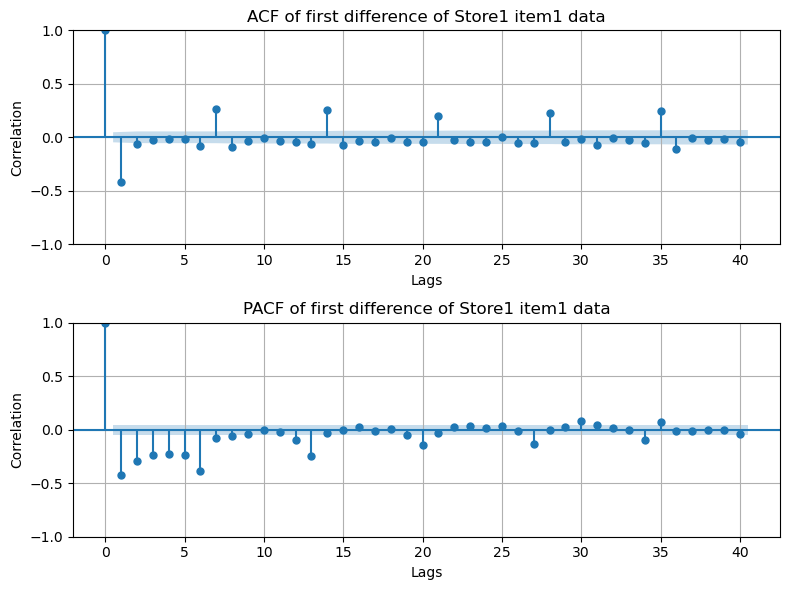

In [34]:
# Plot the ACF and PACF of the first difference of the store1 item1 data

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

sm.graphics.tsa.plot_acf(ts_s1_i1_train_d1, lags=40, ax=ax[0])
ax[0].set_title("ACF of first difference of Store1 item1 data")
ax[0].set_xlabel("Lags")
ax[0].set_ylabel("Correlation")
ax[0].grid(True)

sm.graphics.tsa.plot_pacf(ts_s1_i1_train_d1, lags=40, ax=ax[1])
ax[1].set_title("PACF of first difference of Store1 item1 data")
ax[1].set_xlabel("Lags")
ax[1].set_ylabel("Correlation")
ax[1].grid(True)

plt.tight_layout()

From the ACF and PACF plots of the first difference of store1 item1 data it seems like we can model the time series using an AR coefficient of 6 since the values after that are small. However, the value at lag 13 is significant, also at lag 20 and lag 27. We can try an ARIMA model of order 6,1,0 (p,d,q). 

In [43]:
# Check the shape of the traning data and test data for store1 item1 dataset

print("The shape of the training data is: \n", ts_s1_i1_train.shape,"\n")
print("The shape of the test data is: \n", ts_s1_i1_test.shape)

The shape of the training data is: 
 (1734, 2) 

The shape of the test data is: 
 (92, 2)


In [103]:
# Fit an ARIMA model of order p,d,q = 6,1,0

test_model1 = sm.tsa.ARIMA(ts_s1_i1_train.sales, order=[6,1,0])
test_model1_fit = test_model1.fit()

print(test_model1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1734
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5313.067
Date:                Sat, 13 Jan 2024   AIC                          10640.134
Time:                        20:23:07   BIC                          10678.337
Sample:                             0   HQIC                         10654.263
                               - 1734                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8146      0.022    -37.871      0.000      -0.857      -0.772
ar.L2         -0.7557      0.025    -30.106      0.000      -0.805      -0.707
ar.L3         -0.6938      0.027    -26.154      0.0

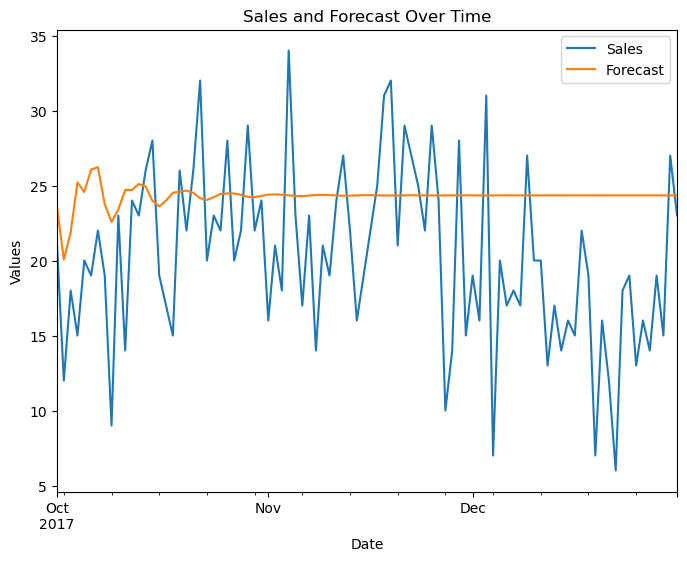

<Figure size 640x480 with 0 Axes>

In [104]:
# Using the ARIMA[6,1,0] model forecast for 3 months in future. 
# Plot the forecasted data overlaid with true sales data
# Calculate the error: MAE, MAPE, SMAPE

start_index = 1734
end_index = 1825

temp1_s1i1_ar610 = ts_s1_i1_test
temp1_s1i1_ar610['forecast'] = test_model1_fit.predict(start = start_index, end= end_index, dynamic= True)  

temp1_s1i1_ar610[['date', 'sales', 'forecast']].set_index('date').plot(figsize=(8, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Sales and Forecast Over Time')
plt.legend(['Sales', 'Forecast'])
plt.show()
plt.tight_layout()

In [105]:
# Define an error function that calculates MAE (mean absolute error), MAPE (mean absolute percentage error) 
# and SMAPE (symmetricabsolute percentage error) for two time series data

def err_calc(y_true, y_pred): 
    
    err_mae = np.mean(np.abs(y_true - y_pred))
    err_mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    err_smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    err_mae = round(err_mae, 2)
    err_mape = round(err_mape, 2)
    err_smape = round(err_smape, 2)
    
    print("MAE: ", err_mae, "\nMAPE: {:.2f}%".format(err_mape), "\nSMAPE: {:.2f}%".format(err_smape))

    return (err_mae, err_mape, err_smape)

In [107]:
# Error in forecasting for store1 item1 data using ARIMA (6,1,0) model

err_calc(temp1_s1i1_ar610.sales, temp1_s1i1_ar610.forecast)

MAE:  5.79 
MAPE: 39.63% 
SMAPE: 28.57%


(5.79, 39.63, 28.57)

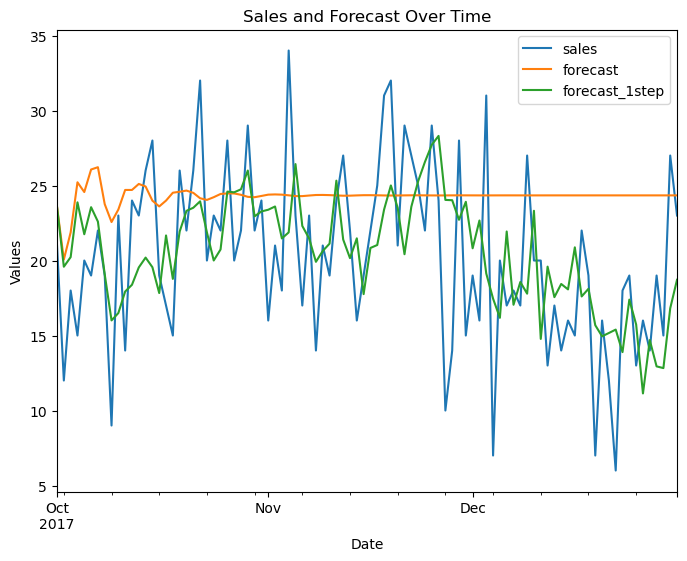

In [125]:
# Using the same ARIMA model predict one sample (day) at a time, append the true sales value and predict again iteratively

past = ts_s1_i1_train.sales.tolist()
forecast_1step = list()
for i in range(len(ts_s1_i1_test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
    model_temp = sm.tsa.ARIMA(past, order=[6,1,0])
    model_fit = model_temp.fit()
    future = model_fit.forecast(steps=1)[0]
    forecast_1step.append(future)
    past.append(ts_s1_i1_test.sales.iloc[i])
    
temp1_s1i1_ar610['forecast_1step'] = [None] * len(temp1_s1i1_ar610)  # Initialize with None
temp1_s1i1_ar610.loc[temp1_s1i1_ar610.index.isin(ts_s1_i1_test.index), 'forecast_1step'] = forecast_1step

temp1_s1i1_ar610[['date', 'sales', 'forecast', 'forecast_1step']].set_index('date').plot(figsize=(8, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Sales and Forecast Over Time')
plt.legend()
plt.show()

In [126]:
# Error in forecasting_1step for store1 item1 data using ARIMA (6,1,0) model

err_calc(temp1_s1i1_ar610.sales, temp1_s1i1_ar610.forecast_1step)

MAE:  4.37 
MAPE: 26.24% 
SMAPE: 22.88%


(4.37, 26.24, 22.88)

Based on the two modeling results shown above here are the observations:

- From the plot we can see that ARIMA [6,1,0] model did not quite accurately model the predictions for store1 item1. 
    - For the first week the prediction seemed to be close to true values but after one month the prediction was constant. 
    - The prediction curve tapered after a few samples.
    - The MAPE error is ~40% and SMAPE is ~29% which seems a little high. 
- When the modeling was used to predict only one sample at a time then the results improved.  
    - Overall seasonal trend can be seen on the predictions which is encouraging. 
    - The MAPE error is ~26% and SMAPE error is ~23% which is a big improvement from the previous model. 

Ideally we would like to predict for all the future values (3 months) using the training data only. Considering the results it is possble that there is some seasonal component that ARIMA is not able to model and/or the order of the ARIMA model was not accrate. We will explore the second possibility in the next section. For different p,d,q values different ARIMA models will eb generated and AIC-BIC will be used to select the best model. Errors from prediction will be explored for all models. 

In [140]:
#p_values = 10
#d_values = 3
#q_values = 10
start_index = 1734
end_index = 1825
model_summary = list()

for p in range(1, p_values+1):
        for d in range(0, d_values+1):
            for q in range(1, q_values+1):
                # define model
                order = (p,d,q)
                temp_model = sm.tsa.ARIMA(ts_s1_i1_train.sales, order=order)
                temp_model_fit = temp_model.fit()
                # extract aic and bic for each model
                aic = temp_model_fit.aic
                bic = temp_model_fit.bic
                # forecast for test data               
                temp1_s1i1_ar = ts_s1_i1_test
                temp1_s1i1_ar['forecast'] = temp_model_fit.predict(start = start_index, end= end_index, dynamic= True) 
                # calulate the error
                err = err_calc(temp1_s1i1_ar.sales, temp1_s1i1_ar.forecast)
                model_summary.append({
                'order': order,
                'aic': aic,
                'bic': bic,
                'MAE': err[0],  
                'MAPE': err[1],  
                'SMAPE': err[2]  
                })
                
                
                

MAE:  5.36 
MAPE: 36.36% 
SMAPE: 26.87%
MAE:  5.38 
MAPE: 36.54% 
SMAPE: 26.97%
MAE:  5.33 
MAPE: 36.14% 
SMAPE: 26.76%
MAE:  5.22 
MAPE: 35.27% 
SMAPE: 26.31%
MAE:  5.17 
MAPE: 34.91% 
SMAPE: 26.12%
MAE:  5.13 
MAPE: 34.59% 
SMAPE: 25.95%
MAE:  5.06 
MAPE: 34.03% 
SMAPE: 25.66%
MAE:  5.22 
MAPE: 35.30% 
SMAPE: 26.31%
MAE:  5.18 
MAPE: 35.00% 
SMAPE: 26.17%
MAE:  5.15 
MAPE: 34.78% 
SMAPE: 26.04%
MAE:  6.06 
MAPE: 41.61% 
SMAPE: 29.61%
MAE:  6.03 
MAPE: 41.45% 
SMAPE: 29.51%
MAE:  6.04 
MAPE: 41.51% 
SMAPE: 29.55%
MAE:  5.94 
MAPE: 40.78% 
SMAPE: 29.14%
MAE:  5.93 
MAPE: 40.72% 
SMAPE: 29.11%
MAE:  5.92 
MAPE: 40.70% 
SMAPE: 29.10%
MAE:  5.93 
MAPE: 40.77% 
SMAPE: 29.13%
MAE:  5.87 
MAPE: 40.26% 
SMAPE: 28.87%
MAE:  5.86 
MAPE: 40.25% 
SMAPE: 28.86%
MAE:  5.76 
MAPE: 39.51% 
SMAPE: 28.47%
MAE:  9.87 
MAPE: 65.69% 
SMAPE: 42.57%
MAE:  4.79 
MAPE: 31.60% 
SMAPE: 24.48%
MAE:  4.98 
MAPE: 33.32% 
SMAPE: 25.30%
MAE:  4.75 
MAPE: 31.28% 
SMAPE: 24.30%
MAE:  6.27 
MAPE: 43.13% 
SMAPE: 30.38%


MAE:  5.62 
MAPE: 37.96% 
SMAPE: 27.67%
MAE:  5.62 
MAPE: 38.04% 
SMAPE: 27.70%
MAE:  5.54 
MAPE: 37.22% 
SMAPE: 27.31%
MAE:  5.54 
MAPE: 36.98% 
SMAPE: 27.25%
MAE:  5.54 
MAPE: 37.14% 
SMAPE: 27.27%
MAE:  5.53 
MAPE: 37.07% 
SMAPE: 27.24%
MAE:  5.81 
MAPE: 39.78% 
SMAPE: 28.62%
MAE:  5.82 
MAPE: 39.91% 
SMAPE: 28.68%
MAE:  5.65 
MAPE: 38.96% 
SMAPE: 27.99%
MAE:  5.72 
MAPE: 39.40% 
SMAPE: 28.26%
MAE:  5.63 
MAPE: 38.11% 
SMAPE: 27.72%
MAE:  5.64 
MAPE: 37.98% 
SMAPE: 27.72%
MAE:  5.57 
MAPE: 37.30% 
SMAPE: 27.41%
MAE:  5.59 
MAPE: 37.44% 
SMAPE: 27.48%
MAE:  5.62 
MAPE: 37.52% 
SMAPE: 27.53%
MAE:  5.55 
MAPE: 37.45% 
SMAPE: 27.39%
MAE:  6.0 
MAPE: 41.15% 
SMAPE: 29.35%
MAE:  6.02 
MAPE: 41.34% 
SMAPE: 29.41%
MAE:  6.03 
MAPE: 41.48% 
SMAPE: 29.49%
MAE:  5.81 
MAPE: 40.24% 
SMAPE: 28.56%
MAE:  5.9 
MAPE: 40.74% 
SMAPE: 28.95%
MAE:  6.02 
MAPE: 41.66% 
SMAPE: 29.41%
MAE:  5.81 
MAPE: 40.22% 
SMAPE: 28.59%
MAE:  5.65 
MAPE: 38.10% 
SMAPE: 27.84%
MAE:  5.77 
MAPE: 39.27% 
SMAPE: 28.39%
MA

LinAlgError: LU decomposition error.

In [141]:
model_summary_df = pd.DataFrame(model_summary)
print(model_summary_df)

         order           aic           bic   MAE   MAPE  SMAPE
0    (1, 0, 1)  10768.245585  10790.078329  5.36  36.36  26.87
1    (1, 0, 2)  10760.965674  10788.256604  5.38  36.54  26.97
2    (1, 0, 3)  10754.092190  10786.841307  5.33  36.14  26.76
3    (1, 0, 4)  10728.417967  10766.625270  5.22  35.27  26.31
4    (1, 0, 5)  10721.977633  10765.643122  5.17  34.91  26.12
..         ...           ...           ...   ...    ...    ...
343  (9, 2, 4)  10621.881260  10698.279710  6.00  41.11  29.36
344  (9, 2, 5)  10599.599934  10681.455415  5.90  40.70  28.97
345  (9, 2, 6)  10579.394263  10666.706777  5.82  40.31  28.61
346  (9, 2, 7)  10590.210087  10682.979632  5.95  40.13  28.92
347  (9, 2, 8)  10459.974792  10558.201370  4.79  31.87  24.49

[348 rows x 6 columns]


In [151]:
min_aic_index = model_summary_df['aic'].idxmin()
min_bic_index = model_summary_df['bic'].idxmin()
min_mae_index = model_summary_df['MAE'].idxmin()
min_mape_index = model_summary_df['MAPE'].idxmin()
min_smape_index = model_summary_df['SMAPE'].idxmin()

print(f"Order with minimum AIC: {model_summary_df.loc[min_aic_index, 'order']}")
print(f"Order with minimum BIC: {model_summary_df.loc[min_bic_index, 'order']}")
print(f"Order with minimum MAE: {model_summary_df.loc[min_mae_index, 'order']}")
print(f"Order with minimum MAPE: {model_summary_df.loc[min_mape_index, 'order']}")
print(f"Order with minimum SMAPE: {model_summary_df.loc[min_smape_index, 'order']}")

Order with minimum AIC: (4, 2, 2)
Order with minimum BIC: (4, 2, 2)
Order with minimum MAE: (3, 3, 9)
Order with minimum MAPE: (8, 3, 9)
Order with minimum SMAPE: (3, 3, 9)


In [152]:
filt_df = model_summary_df[model_summary_df['order'].apply(lambda x: x[1] == 1)]

min_aic_index = filt_df['aic'].idxmin()
min_bic_index = filt_df['bic'].idxmin()
min_mae_index = filt_df['MAE'].idxmin()
min_mape_index = filt_df['MAPE'].idxmin()
min_smape_index = filt_df['SMAPE'].idxmin()

print(f"Order with minimum AIC (when d=1): {filt_df.loc[min_aic_index, 'order']}")
print(f"Order with minimum BIC (when d=1): {filt_df.loc[min_bic_index, 'order']}")
print(f"Order with minimum MAE (when d=1): {filt_df.loc[min_mae_index, 'order']}")
print(f"Order with minimum MAPE (when d=1): {filt_df.loc[min_mape_index, 'order']}")
print(f"Order with minimum SMAPE (when d=1): {filt_df.loc[min_smape_index, 'order']}")

Order with minimum AIC (when d=1): (7, 1, 9)
Order with minimum BIC (when d=1): (7, 1, 9)
Order with minimum MAE (when d=1): (9, 1, 10)
Order with minimum MAPE (when d=1): (9, 1, 10)
Order with minimum SMAPE (when d=1): (9, 1, 10)


In [155]:
print(model_summary_df[model_summary_df['order'] == (3,3,9)])
print(model_summary_df[model_summary_df['order'] == (7,1,9)])
print(model_summary_df[model_summary_df['order'] == (9,1,10)])

         order           aic           bic   MAE   MAPE  SMAPE
118  (3, 3, 9)  10784.351604  10855.285513  4.37  25.69  22.57
         order           aic           bic   MAE   MAPE  SMAPE
258  (7, 1, 9)  10326.680693  10419.460051  5.46  37.05  27.07
          order           aic           bic   MAE  MAPE  SMAPE
339  (9, 1, 10)  10366.099088  10475.251274  4.92  32.9   24.9


From the analysis above the observations are:

    - The lowest SMAPE occurs for order 3,3,9. 
    - Since we know tat d=1 was enough for stationarity we can find the lowest SMAPE when d=1 and that is 9,1,10. 
    - The lowest AIC or BIC is not consistent with the lowest MAPE or SMAPE.

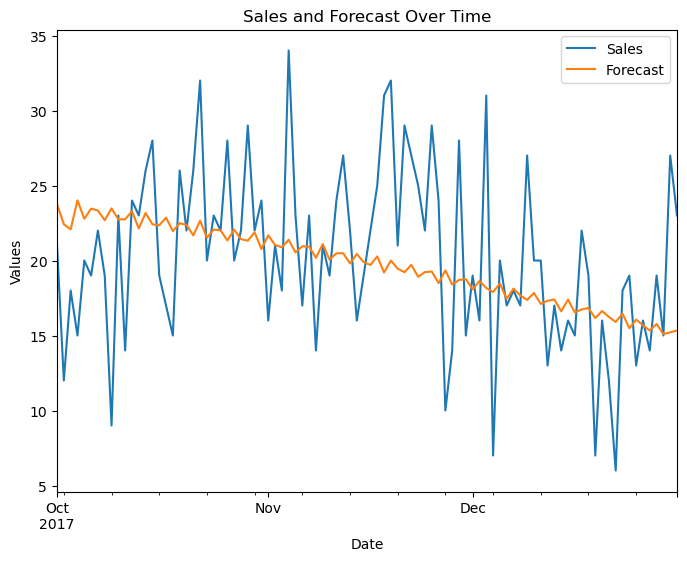

<Figure size 640x480 with 0 Axes>

In [156]:
# Fit an ARIMA model of order p,d,q = 3,3,9

test_model_339 = sm.tsa.ARIMA(ts_s1_i1_train.sales, order=[3,3,9])
test_model_339fit = test_model_339.fit()

start_index = 1734
end_index = 1825

temp1_s1i1_ar339 = ts_s1_i1_test
temp1_s1i1_ar339['forecast'] = test_model_339fit.predict(start = start_index, end= end_index, dynamic= True)  

temp1_s1i1_ar339[['date', 'sales', 'forecast']].set_index('date').plot(figsize=(8, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Sales and Forecast Over Time')
plt.legend(['Sales', 'Forecast'])
plt.show()
plt.tight_layout()

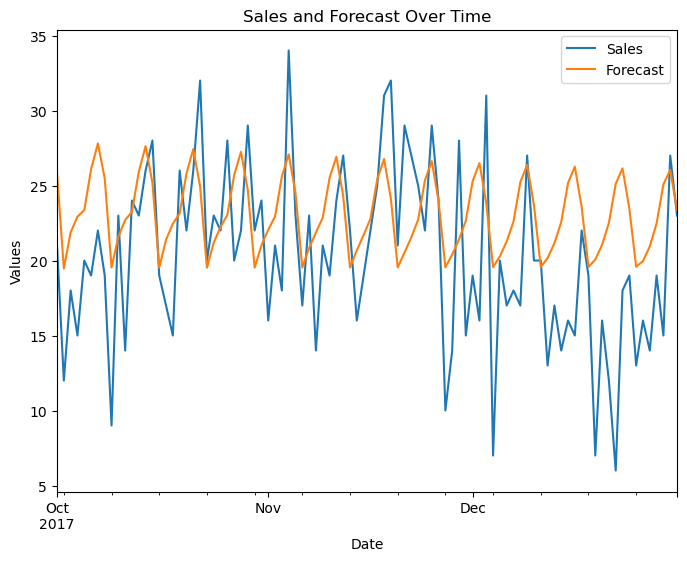

<Figure size 640x480 with 0 Axes>

In [169]:
# Fit an ARIMA model of order p,d,q = 9,1,10

test_model_9110 = sm.tsa.ARIMA(ts_s1_i1_train.sales, order=[9,1,10])
test_model_9110fit = test_model_9110.fit()

start_index = 1734
end_index = 1825

temp1_s1i1_ar9110 = ts_s1_i1_test
temp1_s1i1_ar9110['forecast'] = test_model_9110fit.predict(start = start_index, end= end_index, dynamic= True)  

temp1_s1i1_ar9110[['date', 'sales', 'forecast']].set_index('date').plot(figsize=(8, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Sales and Forecast Over Time')
plt.legend(['Sales', 'Forecast'])
plt.show()
plt.tight_layout()

From the plots above it seems like the models are not doing a great job at predicting the trend. The higher difference model is showing a trend. The best model from visual inspection seems to be the model with order 6,1,0. Next we will check for seasonality using SARIMA. 

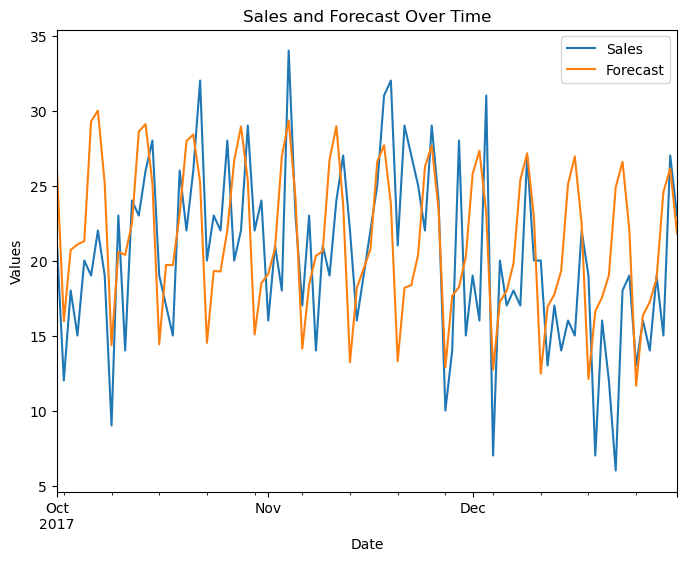

<Figure size 640x480 with 0 Axes>

In [207]:
# Test seasonality effect by using SARIMAX and using a seasonal value of 7 as we observed from time series plot and ACF

test_model_6107 = sm.tsa.SARIMAX(ts_s1_i1_train.sales, order=[6,1,0], seasonal_order=[6,1,0,7])
test_model_6107fit = test_model_6107.fit()

start_index = 1734
end_index = 1825

temp1_s1i1_ar6107 = ts_s1_i1_test
temp1_s1i1_ar6107['forecast'] = test_model_6107fit.predict(start = start_index, end= end_index, dynamic= True)  

temp1_s1i1_ar6107[['date', 'sales', 'forecast']].set_index('date').plot(figsize=(8, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Sales and Forecast Over Time')
plt.legend(['Sales', 'Forecast'])
plt.show()
plt.tight_layout()

In [180]:
# Error in forecasting for store1 item1 data using ARIMA (6,1,0) model

err_calc(temp1_s1i1_ar6107.sales, temp1_s1i1_ar6107.forecast)

MAE:  4.8 
MAPE: 29.02% 
SMAPE: 24.49%


(4.8, 29.02, 24.49)

From the prediction plot, it seems like SARIMAX does a better job at prediction than ARIMA. The MAPE error is lowered from 40% to 29%. SMAPE error is also less from 295 to 24%. 

Next we can test the effect of exogenous variables on prediction. 

In [199]:
# Define exogenous variables

ext_var_list = ['date', 'year', 'month', 'day_of_year', 'day_of_week']

ts_s1i1_exo = df_train[(df_train['store'] == 1) & (df_train['item'] == 1)][ext_var_list]
ts_s1i1_exo_train = ts_s1i1_exo[ts_s1i1_exo['date'] < '2017-10-01']
ts_s1i1_exo_test = ts_s1i1_exo[ts_s1i1_exo['date'] >= '2017-10-01']

ts_s1i1_exo_train1 = ts_s1i1_exo_train.drop(columns=['date']).copy()
ts_s1i1_exo_test1 = ts_s1i1_exo_test.drop(columns=['date']).copy()

In [200]:
ts_s1i1_exo_train1.shape

(1734, 4)

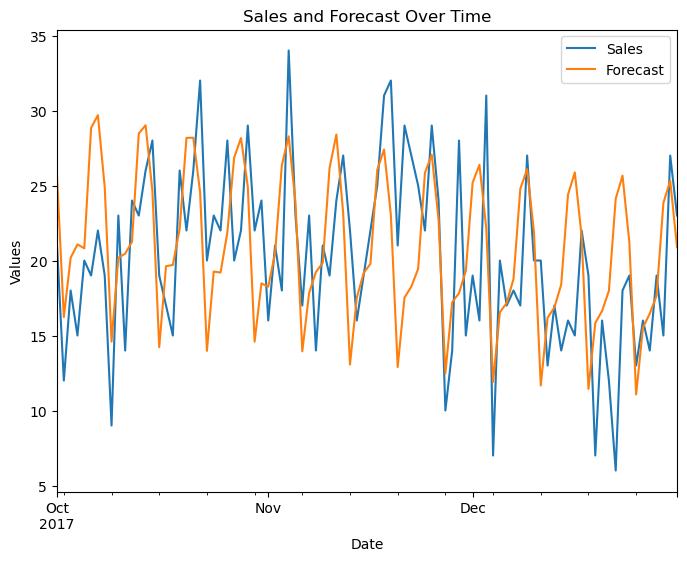

<Figure size 640x480 with 0 Axes>

In [215]:
# Test SARIMAX using exogenous variables. 

test_model_6107 = sm.tsa.SARIMAX(ts_s1_i1_train.sales, exog=ts_s1i1_exo_train1, order=[4,1,5], seasonal_order=[6,1,0,7])
test_model_6107fit = test_model_6107.fit()

start_index = 1734
end_index = 1825

temp1_s1i1_ar6107 = ts_s1_i1_test
temp1_s1i1_ar6107['forecast'] = test_model_6107fit.predict(start = start_index, end= end_index, exog=ts_s1i1_exo_test1, dynamic=True)  

temp1_s1i1_ar6107[['date', 'sales', 'forecast']].set_index('date').plot(figsize=(8, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Sales and Forecast Over Time')
plt.legend(['Sales', 'Forecast'])
plt.show()
plt.tight_layout()

In [214]:
# Error in forecasting for store1 item1 data using SARIMAX and exogenous variables

err_calc(temp1_s1i1_ar6107.sales, temp1_s1i1_ar6107.forecast)

MAE:  4.73 
MAPE: 28.34% 
SMAPE: 24.24%


(4.73, 28.34, 24.24)

The effect of exogenous variables is small. The error is slightly lowered and the prediction plot looks very similar. Finally, the best prediction is using SARIMAX (seasonal ARIMA) with exogenous variables. 